In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import arviz as az
import pymc3 as pm

sns.set(style="ticks", context='poster')
%matplotlib inline

RANDOM_SEED = 8927

## Figure 2a

In [2]:
MF_strains = pd.read_excel('./raw_data/fig2/mf_within_strain.xlsx')

In [3]:
MF_strains.head()

,Strain,MF
0,RSA113,59.574468
1,RSA113,67.741935
2,RSA113,65.048544
3,RSD029,70.212766
4,RSD029,53.521127


<Figure size 432x288 with 0 Axes>

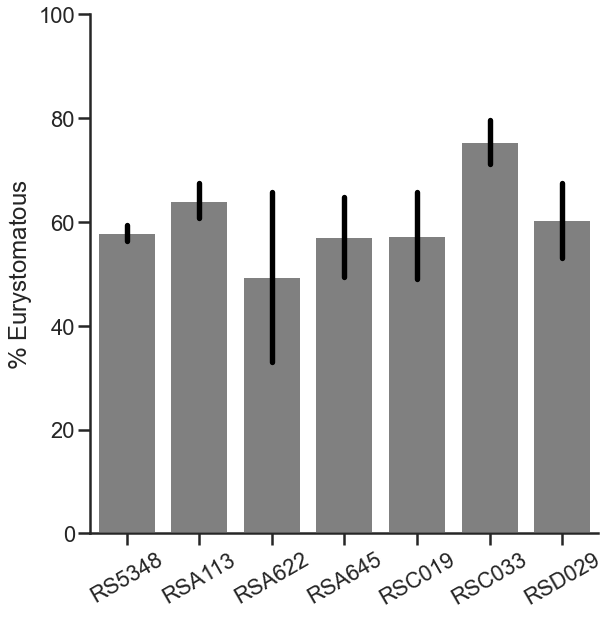

In [4]:
fig = plt.figure()
g = sns.catplot(data=MF_strains, kind="bar", x="Strain", y='MF', ci="sd", color='grey', errcolor='black', order=['RS5348', 'RSA113', 'RSA622', 'RSA645', 'RSC019', 'RSC033', 'RSD029'],alpha=1, height=8)
g.set_xticklabels(rotation=30)
g.set_ylabels(r'$\%$ Eurystomatous')
plt.ylim(0, 100)
plt.xlabel(r' ',labelpad=0)
plt.savefig('./fig2a.pdf', bbox_inches='tight', dpi=300)

## Figure 2b

### Bayesian method to compare two groups:

In order to estimate the highest-density interval (HDI) for the means and the difference in means of two groups, we implemented a Bayesian alternative to t-test, based on Kruschke, John. (2012) **Bayesian estimation supersedes the t-test.** _Journal of Experimental Psychology_.

**Likelihood functions:**

For sample $a$ and $b$, we define the following likelihood functions:

$$y_{i}^{a} \sim \mathcal{T}(\nu, \mu_{a}, \sigma_{a})$$

$$y_{i}^{b} \sim \mathcal{T}(\nu, \mu_{b}, \sigma_{b})$$

**Prior distributions:**

For the mean of sample $i$, we set the prior to normal, with the pooled mean of the two samples ($\bar{x}$) and twice the pooled standard deviation ($s$):
$$\mu_i \sim  \mathcal{N}(\bar{x}, 2 s)$$

The standard deviations have uniform prior from:

$$\mathrm{Uniform}(1, 300)$$

Following Krushke, $\nu=30$. Higher values of $\nu$ results in the distribution converging to the normal distribution. 

**Computation details:**

For each comparison, we use `PyMC3 3.9.3`, using No U-Turn Sampler (NUTS) ($4$ chains). We ensure the the chain have converged, i.e., $\hat{R} \approx 1$. We also ensure that ESS $\geq 10000$ for stable estimates of HDIs.

In [5]:
def bayesian_robust_two_groups(sample_1, sample_2):
    pooled = np.concatenate([sample_1, sample_2])
    m_s = np.mean(pooled)
    std_s = np.std(pooled) * 2
    σ_low = 1
    σ_high = 300

    with pm.Model() as model:
        group1_mean = pm.Normal("group1_mean", mu=m_s, sd=std_s)
        group2_mean = pm.Normal("group2_mean", mu=m_s, sd=std_s)
        group1_std = pm.Uniform("group1_std", lower=σ_low, upper=σ_high)
        group2_std = pm.Uniform("group2_std", lower=σ_low, upper=σ_high)
        ν = pm.Exponential("ν_minus_one", 1 / 29.0) + 1
        λ1 = group1_std ** -2
        λ2 = group2_std ** -2
        group1 = pm.StudentT("observed1", nu=ν, mu=group1_mean, lam=λ2, observed=sample_1)
        group2 = pm.StudentT("observed2", nu=ν, mu=group2_mean, lam=λ1, observed=sample_2)
        diff_of_means = pm.Deterministic("difference of means", group1_mean - group2_mean)
        diff_of_stds = pm.Deterministic("difference of stds", group1_std - group2_std)
        effect_size = pm.Deterministic(
            "effect size", diff_of_means / np.sqrt((group1_std ** 2 + group2_std ** 2) / 2)
        )
        
    with model:
        trace = pm.sample(10000, random_seed=RANDOM_SEED, return_inferencedata=False)
    with model:
        stat_results = az.summary(trace, round_to=2, hdi_prob=0.95)
    with model:
        data = az.convert_to_dataset(trace)
    diff_dist = np.array(data['difference of means']).flatten()
    prop = np.round(len([i for i in diff_dist if i > 0])/len(diff_dist), decimals=2)
    return stat_results, prop

In [6]:
intra_strain_f = pd.read_excel('./raw_data/fig2/fecundity_within_strain.xlsx')

In [7]:
intra_strain_f.head()

,Strain,MF,Fecundity
0,RS5348,Eu,100
1,RS5348,Eu,89
2,RS5348,Eu,156
3,RS5348,Eu,115
4,RS5348,Eu,90


In [8]:
strains = ['RS5348', 'RSA113', 'RSA622', 'RSA645', 'RSC019', 'RSC033', 'RSD029']
stat_dic = {}
diff_positive = {}
for strain in strains:
    sample_1 = intra_strain_f[(intra_strain_f['Strain']==strain) & (intra_strain_f['MF']=='St')]['Fecundity']
    sample_2 = intra_strain_f[(intra_strain_f['Strain']==strain) & (intra_strain_f['MF']=='Eu')]['Fecundity']
    output = bayesian_robust_two_groups(sample_1, sample_2)
    stat_dic[strain], diff_positive[strain] = output

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, group2_std, group1_std, group2_mean, group1_mean]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 17 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, group2_std, group1_std, group2_mean, group1_mean]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 17 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, group2_std, group1_std, group2_mean, group1_mean]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 16 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, group2_std, group1_std, group2_mean, group1_mean]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 18 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, group2_std, group1_std, group2_mean, group1_mean]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 17 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, group2_std, group1_std, group2_mean, group1_mean]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 17 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, group2_std, group1_std, group2_mean, group1_mean]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 19 seconds.


In [9]:
for i in strains:
    print('Strain:' +i, '\n', stat_dic[i]['ess_mean'])

Strain:RS5348 
 group1_mean            44288.58
group2_mean            52011.46
group1_std             40484.90
group2_std             46105.51
ν_minus_one            40548.75
difference of means    47002.57
difference of stds     47861.82
effect size            48410.67
Name: ess_mean, dtype: float64
Strain:RSA113 
 group1_mean            38494.22
group2_mean            35369.72
group1_std             31425.22
group2_std             36190.61
ν_minus_one            31626.48
difference of means    38678.71
difference of stds     50760.35
effect size            38355.39
Name: ess_mean, dtype: float64
Strain:RSA622 
 group1_mean            53904.73
group2_mean            58497.36
group1_std             47137.68
group2_std             50387.56
ν_minus_one            45293.25
difference of means    56920.94
difference of stds     52755.12
effect size            57732.70
Name: ess_mean, dtype: float64
Strain:RSA645 
 group1_mean            29696.94
group2_mean            33176.32
group1_std 

In [10]:
for i in strains:
    print('Strain:' +i, '\n', stat_dic[i]['r_hat'])

Strain:RS5348 
 group1_mean            1.0
group2_mean            1.0
group1_std             1.0
group2_std             1.0
ν_minus_one            1.0
difference of means    1.0
difference of stds     1.0
effect size            1.0
Name: r_hat, dtype: float64
Strain:RSA113 
 group1_mean            1.0
group2_mean            1.0
group1_std             1.0
group2_std             1.0
ν_minus_one            1.0
difference of means    1.0
difference of stds     1.0
effect size            1.0
Name: r_hat, dtype: float64
Strain:RSA622 
 group1_mean            1.0
group2_mean            1.0
group1_std             1.0
group2_std             1.0
ν_minus_one            1.0
difference of means    1.0
difference of stds     1.0
effect size            1.0
Name: r_hat, dtype: float64
Strain:RSA645 
 group1_mean            1.0
group2_mean            1.0
group1_std             1.0
group2_std             1.0
ν_minus_one            1.0
difference of means    1.0
difference of stds     1.0
effect size    

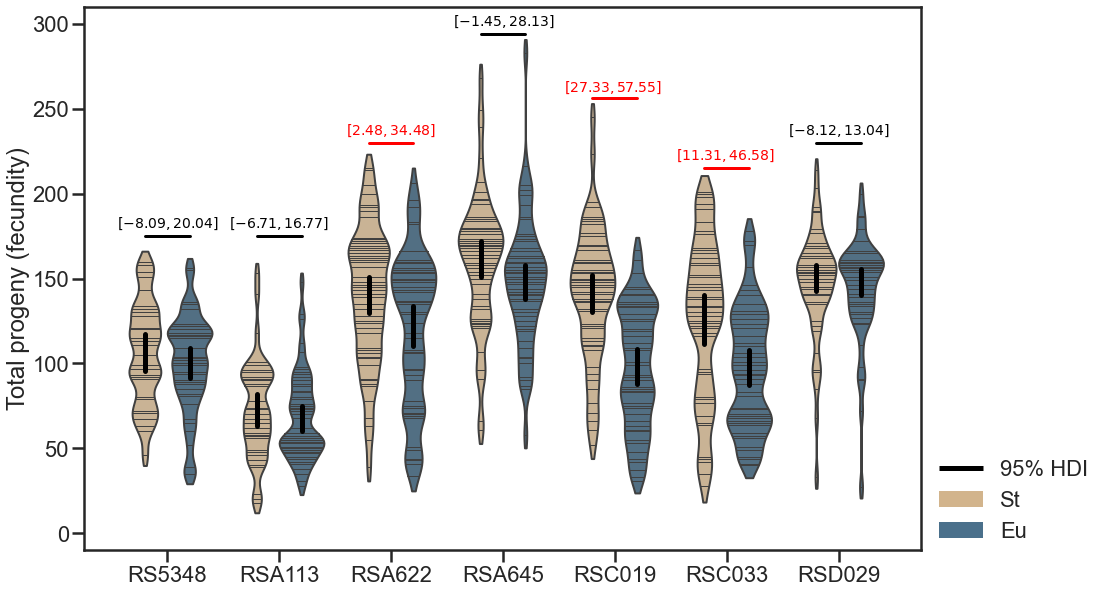

In [12]:
fig = plt.figure(figsize=(15,10))

g = sns.violinplot(data=intra_strain_f, x="Strain", y="Fecundity", hue="MF",
               split=False, inner="stick", bw=.2, cut=1, linewidth=2,
               palette={"Eu": "#4a708bff", "St": "#d2b48cff"}, zorder=0, hue_order=['St', 'Eu'])
space = 0
for i in strains:
    if space==0:
        plt.vlines(-0.2+space, stat_dic[i]['hdi_2.5%']['group1_mean'], stat_dic[i]['hdi_97.5%']['group1_mean'],  colors='black', linestyles='-', linewidth=5, capstyle='round', label='95% HDI',clip_on=False, zorder=10)
        plt.vlines(0.2+space, stat_dic[i]['hdi_2.5%']['group2_mean'], stat_dic[i]['hdi_97.5%']['group2_mean'],  colors='black', linestyles='-', linewidth=5, capstyle='round',clip_on=False, zorder=10)
    else:
        plt.vlines(-0.2+space, stat_dic[i]['hdi_2.5%']['group1_mean'], stat_dic[i]['hdi_97.5%']['group1_mean'],  colors='black', linestyles='-', linewidth=5, capstyle='round',clip_on=False, zorder=10)
        plt.vlines(0.2+space, stat_dic[i]['hdi_2.5%']['group2_mean'], stat_dic[i]['hdi_97.5%']['group2_mean'],  colors='black', linestyles='-', linewidth=5, capstyle='round',clip_on=False, zorder=10)
    space += 1

plt.text(-0.4-0.05, 180, r'$['+str(stat_dic['RS5348']['hdi_2.5%']['difference of means']) + ',' + str(stat_dic['RS5348']['hdi_97.5%']['difference of means']) + ']$', color='black', fontsize=14)
plt.hlines(175, -0.2, 0.2,  colors='black', linestyles='-', linewidth=3, capstyle='round',clip_on=False)

plt.text(0.6-0.05, 180, r'$['+str(stat_dic['RSA113']['hdi_2.5%']['difference of means']) + ',' + str(stat_dic['RSA113']['hdi_97.5%']['difference of means']) + ']$', color='black', fontsize=14)
plt.hlines(175, 0.8, 1.2,  colors='black', linestyles='-', linewidth=3, capstyle='round',clip_on=False)

plt.text(2.6-0.05, 299, r'$['+str(stat_dic['RSA645']['hdi_2.5%']['difference of means']) + ',' + str(stat_dic['RSA645']['hdi_97.5%']['difference of means']) + ']$', color='black', fontsize=14)
plt.hlines(294, 2.8, 3.2,  colors='black', linestyles='-', linewidth=3, capstyle='round',clip_on=False)

plt.text(5.6-0.05, 235, r'$['+str(stat_dic['RSD029']['hdi_2.5%']['difference of means']) + ',' + str(stat_dic['RSD029']['hdi_97.5%']['difference of means']) + ']$', color='black', fontsize=14)
plt.hlines(230, 5.8, 6.2,  colors='black', linestyles='-', linewidth=3, capstyle='round',clip_on=False)


plt.text(1.6,235, r'$['+str(stat_dic['RSA622']['hdi_2.5%']['difference of means']) + ',' + str(stat_dic['RSA622']['hdi_97.5%']['difference of means']) + ']$', color='red', fontsize=14)
plt.hlines(230, 1.8, 2.2,  colors='red', linestyles='-', linewidth=3, capstyle='round', clip_on=False)

plt.text(3.55,260, r'$['+str(stat_dic['RSC019']['hdi_2.5%']['difference of means']) + ',' + str(stat_dic['RSC019']['hdi_97.5%']['difference of means']) + ']$', color='red', fontsize=14)
plt.hlines(256, 3.8, 4.2,  colors='red', linestyles='-', linewidth=3, capstyle='round',clip_on=False)

plt.text(4.55,220, r'$['+str(stat_dic['RSC033']['hdi_2.5%']['difference of means']) + ',' + str(stat_dic['RSC033']['hdi_97.5%']['difference of means']) + ']$', color='red', fontsize=14)
plt.hlines(215, 4.8, 5.2,  colors='red', linestyles='-', linewidth=3, capstyle='round',clip_on=False)
plt.xlabel(r' ',labelpad=0)
plt.ylabel(r'Total progeny (fecundity)',labelpad=2)

plt.bar(0,0, edgecolor='black',linewidth=0, color= "#d2b48cff", label="St")
plt.bar(0,0, edgecolor='black',linewidth=0, color= "#4a708bff", label="Eu")

handles, labels = plt.gca().get_legend_handles_labels()

plt.legend(handles[2:], labels[2:], loc=(1.01,0),frameon=False, edgecolor='white')

plt.ylim(-10, 310)

plt.savefig('./fig2b.pdf', bbox_inches='tight', dpi=300)

## Fig 2c

In [26]:
mf_clades = pd.read_excel('./raw_data/fig2/mf_between_strains.xlsx')

In [27]:
mf_clades.head()

,Strain,Count,Clade,MF
0,RSC011,20,Clade B,Stenostomatous
1,RSC011,32,Clade B,Stenostomatous
2,RSC011,48,Clade B,Stenostomatous
3,RSA076,100,Clade B,Eurystomatous
4,RSA076,100,Clade B,Eurystomatous


<Figure size 432x288 with 0 Axes>

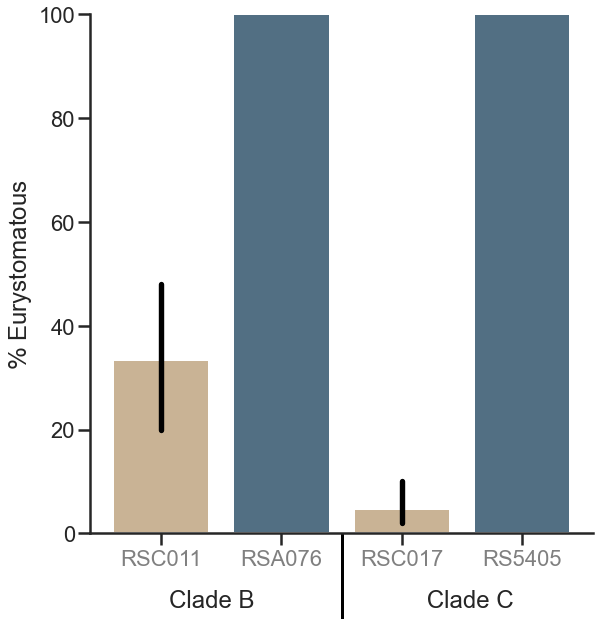

In [28]:
fig = plt.figure()
g = sns.catplot(data=mf_clades, aspect=1, errcolor='black', palette= ["#d2b48cff" , "#4a708bff", "#d2b48cff", "#4a708bff"], order=['RSC011','RSA076', 'RSC017', 'RS5405'], x="Strain", y='Count',  kind="bar", alpha=1, height=8,clip_on=True)
g.set_xticklabels(rotation=0, color='grey')


plt.bar(0,0, color= "#4a708bff", label="Eu biased")
plt.bar(0,0, color= "#d2b48cff", label="St biased")

#plt.hlines(105, 0, 1,  colors='black', linestyles='-', linewidth=3, capstyle='round',clip_on=False)

plt.vlines(1.5, -30, -0.1,  colors='black', linestyles='-', linewidth=3, capstyle='round',clip_on=False)
#plt.hlines(-8, 0, 3,  colors='black', linestyles='-', linewidth=3, capstyle='round',clip_on=False)

plt.ylim(0, 100)
g.set_ylabels(r'$\%$ Eurystomatous')
g.set_xlabels(r'Clade B                          Clade C', labelpad=20)
plt.savefig('./fig2c.jpeg', bbox_inches='tight', dpi=300)

## Fig 2d

In [13]:
fec_clades = pd.read_excel('./raw_data/fig2/fecundity_between_strains.xlsx')

In [14]:
fec_clades.head()

,Strain,Progeny Count,Clade,MF
0,RSC011,186,Clade B,St
1,RSC011,204,Clade B,St
2,RSC011,68,Clade B,St
3,RSC011,143,Clade B,St
4,RSC011,146,Clade B,St


In [15]:
strains = [('RSC011', 'RSA076'), ('RSC017', 'RS5405')]
stat_dic = {}
diff_positive = {}
for strain in strains:
    sample_1 = fec_clades[fec_clades['Strain']==strain[0]]['Progeny Count']
    sample_2 = fec_clades[fec_clades['Strain']==strain[1]]['Progeny Count']
    output = bayesian_robust_two_groups(sample_1, sample_2)
    stat_dic[strain], diff_positive[strain] = output

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, group2_std, group1_std, group2_mean, group1_mean]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 20 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, group2_std, group1_std, group2_mean, group1_mean]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 17 seconds.


In [16]:
stat_dic

{('RSC011',
  'RSA076'):                        mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
 group1_mean          173.11   6.60    159.80     185.68       0.05     0.03   
 group2_mean          155.91   6.49    142.80     168.20       0.05     0.04   
 group1_std            31.45   7.53     18.36      46.26       0.07     0.05   
 group2_std            34.38   7.33     20.79      48.86       0.06     0.04   
 ν_minus_one            8.20  14.79      0.05      34.74       0.12     0.08   
 difference of means   17.20   8.49      0.42      33.67       0.05     0.04   
 difference of stds    -2.93   7.24    -17.42      11.20       0.04     0.03   
 effect size            0.54   0.28      0.00       1.08       0.00     0.00   
 
                      ess_mean    ess_sd  ess_bulk  ess_tail  r_hat  
 group1_mean          20055.49  20055.49  20307.51  20799.06    1.0  
 group2_mean          17058.45  17058.45  17493.96  19034.09    1.0  
 group1_std           12754.75  12754.75  12

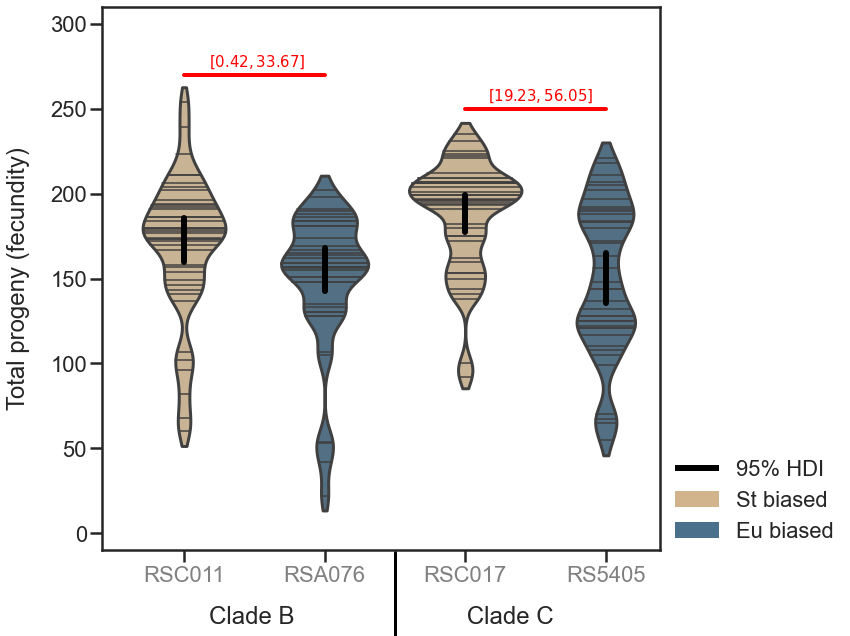

In [17]:
fig = plt.figure(figsize=(10,10))


g = sns.violinplot(data=fec_clades,  x="Strain", y="Progeny Count",
               split=False, inner="stick", bw=.2, cut=1, linewidth=3, palette= ["#d2b48cff" , "#4a708bff", "#d2b48cff", "#4a708bff"], order=['RSC011','RSA076', 'RSC017', 'RS5405'])

plt.bar(0,0, edgecolor='black',linewidth=0, color= "#d2b48cff", label="St biased")
plt.bar(0,0, edgecolor='black',linewidth=0, color= "#4a708bff", label="Eu biased")

plt.vlines(0, stat_dic[('RSC011','RSA076')]['hdi_2.5%']['group1_mean'], stat_dic[('RSC011','RSA076')]['hdi_97.5%']['group1_mean'],  colors='black', linestyles='-', linewidth=6, capstyle='round', label='95% HDI',clip_on=False, zorder=10)
plt.vlines(1, stat_dic[('RSC011','RSA076')]['hdi_2.5%']['group2_mean'], stat_dic[('RSC011','RSA076')]['hdi_97.5%']['group2_mean'],  colors='black', linestyles='-', linewidth=6, capstyle='round',clip_on=False, zorder=10)

plt.vlines(2, stat_dic[('RSC017', 'RS5405')]['hdi_2.5%']['group1_mean'], stat_dic[('RSC017', 'RS5405')]['hdi_97.5%']['group1_mean'],  colors='black', linestyles='-', linewidth=6, capstyle='round', clip_on=False, zorder=10)
plt.vlines(3, stat_dic[('RSC017', 'RS5405')]['hdi_2.5%']['group2_mean'], stat_dic[('RSC017', 'RS5405')]['hdi_97.5%']['group2_mean'],  colors='black', linestyles='-', linewidth=6, capstyle='round',clip_on=False, zorder=10)

plt.xlabel(r'Wild isolates',labelpad=20)
plt.ylabel(r'Total progeny (fecundity)',labelpad=20)
plt.ylim(0, 300)
plt.xlabel(r'Clade B                          Clade C', labelpad=20)
plt.vlines(1.5, -70, -11,  colors='black', linestyles='-', linewidth=3, capstyle='round',clip_on=False)
plt.xticks(color='grey')

plt.text(0.175,275, r'$['+str(stat_dic[('RSC011','RSA076')]['hdi_2.5%']['difference of means']) + ',' + str(stat_dic[('RSC011','RSA076')]['hdi_97.5%']['difference of means']) + ']$', fontsize=15,  color='red')
plt.hlines(270, 0., 1.,  colors='red', linestyles='-', linewidth=4, capstyle='round',  clip_on=False)

plt.text(2.16,255, r'$['+str(stat_dic[('RSC017', 'RS5405')]['hdi_2.5%']['difference of means']) + ',' + str(stat_dic[('RSC017', 'RS5405')]['hdi_97.5%']['difference of means']) + ']$', fontsize=15,  color='red')
plt.hlines(250, 2., 3.,  colors='red', linestyles='-', linewidth=4, capstyle='round',clip_on=False)


plt.legend(loc=(1.01,0),frameon=False)

plt.ylim(-10, 310)

plt.savefig('./fig2d.pdf', bbox_inches='tight', dpi=300)

## Fig 2e

In [18]:
dev_isolates = pd.read_excel('./raw_data/fig2/dev_speed_OP50_between_clades.xlsx')

In [19]:
dev_isolates.head()

,Strain,Stage,Percentage,Clade
0,RSC011,Eggs,0.000000,Clade B
1,RSC011,J2,0.380228,Clade B
2,RSC011,J3,0.760456,Clade B
3,RSC011,J4,38.783270,Clade B
4,RSC011,YA,60.076046,Clade B


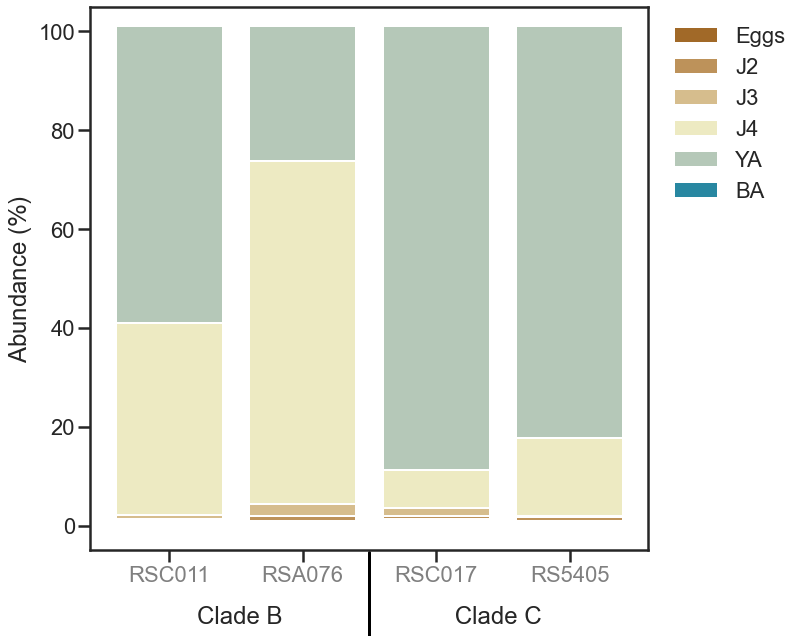

In [57]:
grad = ['#A16928','#bd925a','#d6bd8d','#edeac2','#b5c8b8','#2887a1'] 

fig, ax = plt.subplots(1, 1, figsize=(10,10))

for ind, pos in zip(['RSC011','RSA076', 'RSC017', 'RS5405'], [0, 1, 2, 3]):
    count = 0
    bot = 1
    for stage in ['Eggs', 'J2', 'J3', 'J4', 'YA', 'BA']:
        val = dev_isolates[(dev_isolates['Strain']==ind) & (dev_isolates['Stage']==stage)]['Percentage']
        ax.bar(pos, val, bottom=bot, color=grad[count], label=stage)
        bot += float(val)
        count += 1
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(['RSC011','RSA076', 'RSC017', 'RS5405'], color='gray')        

handles, labels = plt.gca().get_legend_handles_labels()

plt.legend(handles[:6], labels[:6], bbox_to_anchor=(1.01, 1),frameon=False)

ax.set_ylabel(r'Abundance ($\%$)')
ax.set_ylim(-5, 105)
ax.set_xlabel(r'Clade B                          Clade C', labelpad=20)
plt.vlines(1.5, -40, -5.3,  colors='black', linestyles='-', linewidth=3, capstyle='round',clip_on=False)
plt.savefig('./fig2e.pdf', bbox_inches='tight', dpi=300)

## Fig 3a

In [29]:
mf_isolate = pd.read_csv('./raw_data/fig3/MF_on_novo_op50.csv', sep='\t')

In [30]:
mf_isolate.head()

,Strain,Culture,Date,Number of Eu animals,Total number of animals counted,Replicate,Eu
0,RSC019,OP50,02.08.21,33,50,1,66
1,RSC019,OP50,06.08.21,30,50,2,60
2,RSC019,OP50,10.08.21,23,50,3,46
3,RSC017,OP50,02.08.21,1,50,1,2
4,RSC017,OP50,06.08.21,5,50,2,10


<Figure size 720x720 with 0 Axes>

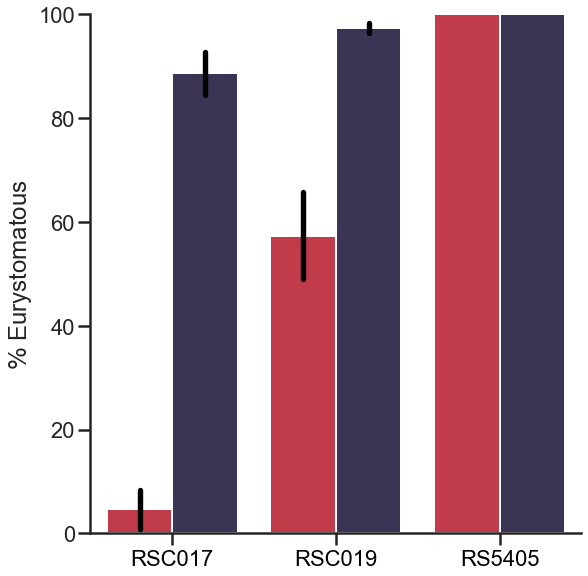

In [31]:
fig = plt.figure(figsize=(10,10))
g = sns.catplot(data=mf_isolate, aspect=1, x="Strain", y='Eu', kind="bar", ci='sd', hue='Culture',order=['RSC017','RSC019','RS5405'], alpha=1, height=8, palette={"Novo": '#392F5A', "OP50": '#D72638'}, errcolor='black')
g._legend.remove()
g.set_xticklabels(rotation=0, color='black')

g.set_ylabels(r'$\%$ Eurystomatous')
g.set_xlabels(r'', labelpad=10)

handles, labels = plt.gca().get_legend_handles_labels()
plt.ylim(0, 100)
plt.savefig('./fig3a.jpeg', bbox_inches='tight', dpi=300)

## Fig 3b

In [20]:
fec_isolate = pd.read_excel('./raw_data/fig3/fecundity_novo_op50.xlsx')

In [21]:
fec_isolate.head()

,Worm ID,Strain,Total Progeny Count,Culture Condition
0,1,RSC017,149,Novosphingobium sp.
1,2,RSC017,155,Novosphingobium sp.
2,3,RSC017,132,Novosphingobium sp.
3,4,RSC017,129,Novosphingobium sp.
4,5,RSC017,132,Novosphingobium sp.


In [22]:
strains = ['RSC017', 'RSC019', 'RS5405']
stat_dic = {}
diff_positive = {}
for strain in strains:
    sample_1 = fec_isolate[(fec_isolate['Strain']==strain) & (fec_isolate['Culture Condition']=="Novosphingobium sp.")]["Total Progeny Count"]
    sample_2 = fec_isolate[(fec_isolate['Strain']==strain) & (fec_isolate['Culture Condition']=="E. coli ")]["Total Progeny Count"]
    output = bayesian_robust_two_groups(sample_1, sample_2)
    stat_dic[strain], diff_positive[strain] = output

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, group2_std, group1_std, group2_mean, group1_mean]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 18 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, group2_std, group1_std, group2_mean, group1_mean]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 18 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, group2_std, group1_std, group2_mean, group1_mean]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 16 seconds.


In [23]:
stat_dic

{'RSC017':                        mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
 group1_mean          136.68   4.03    128.76     144.61       0.02     0.02   
 group2_mean          188.76   5.49    177.72     199.24       0.03     0.02   
 group1_std            30.74   4.76     21.44      40.23       0.03     0.02   
 group2_std            25.78   3.84     18.27      33.49       0.03     0.02   
 ν_minus_one           22.33  24.57      0.54      72.34       0.16     0.11   
 difference of means  -52.08   6.75    -65.89     -39.28       0.04     0.03   
 difference of stds     4.96   5.19     -5.36      15.01       0.03     0.02   
 effect size           -1.86   0.38     -2.65      -1.16       0.00     0.00   
 
                      ess_mean    ess_sd  ess_bulk  ess_tail  r_hat  
 group1_mean          30134.98  30089.30  30142.38  28043.68    1.0  
 group2_mean          26691.97  26671.53  26679.34  27794.28    1.0  
 group1_std           21145.26  21145.26  20600.88  16254.

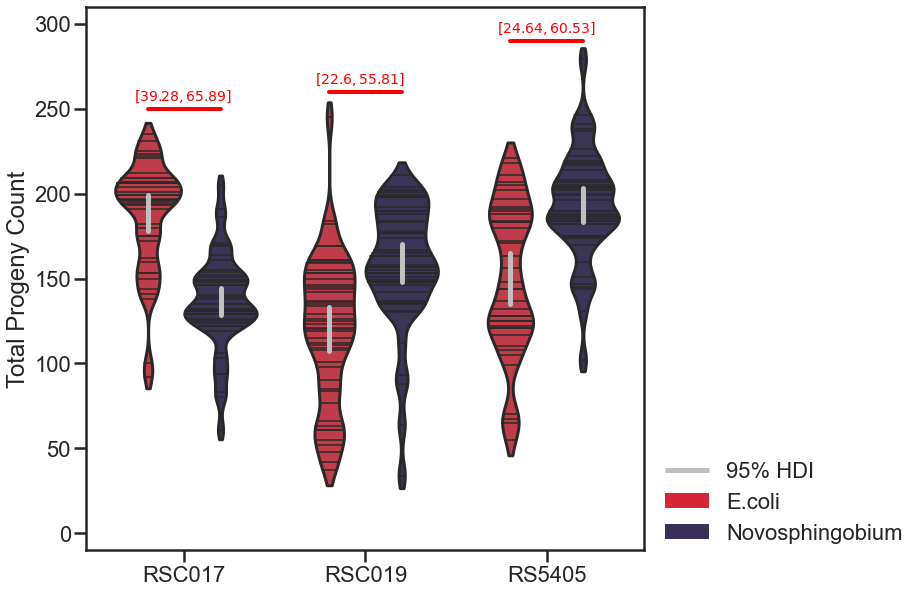

In [24]:
fig = plt.figure(figsize=(10,10))

g = sns.violinplot(data=fec_isolate,  x="Strain", y="Total Progeny Count",
               split=False, inner="stick", hue='Culture Condition', hue_order=["E. coli ", "Novosphingobium sp."], bw=.2, cut=1, linewidth=3, saturation=0.75, order=['RSC017','RSC019','RS5405'], palette={"E. coli ": '#D72638', "Novosphingobium sp.": '#392F5A'})

plt.ylim(-10, 310)

space = 0
for i in strains:
    if space==0:
        plt.vlines(-0.2+space, stat_dic[i]['hdi_2.5%']['group2_mean'], stat_dic[i]['hdi_97.5%']['group2_mean'],  colors='silver', linestyles='-', linewidth=5, capstyle='round', label='95% HDI',clip_on=False, zorder=10)
        plt.vlines(0.2+space, stat_dic[i]['hdi_2.5%']['group1_mean'], stat_dic[i]['hdi_97.5%']['group1_mean'],  colors='silver', linestyles='-', linewidth=5, capstyle='round',clip_on=False, zorder=10)
    else:
        plt.vlines(-0.2+space, stat_dic[i]['hdi_2.5%']['group2_mean'], stat_dic[i]['hdi_97.5%']['group2_mean'],  colors='silver', linestyles='-', linewidth=5, capstyle='round',clip_on=False, zorder=10)
        plt.vlines(0.2+space, stat_dic[i]['hdi_2.5%']['group1_mean'], stat_dic[i]['hdi_97.5%']['group1_mean'],  colors='silver', linestyles='-', linewidth=5, capstyle='round',clip_on=False, zorder=10)
    space += 1

plt.xlabel(r'',labelpad=20)

plt.text(-0.28,255,  r'$['+str(-1*stat_dic['RSC017']['hdi_97.5%']['difference of means']) + ',' + str(-1*stat_dic['RSC017']['hdi_2.5%']['difference of means']) + ']$', color='red', fontsize=14)
plt.hlines(250, -0.2, 0.2,  colors='red', linestyles='-', linewidth=4, capstyle='round', clip_on=False)

plt.text(0.72,265, r'$['+str(stat_dic['RSC019']['hdi_2.5%']['difference of means']) + ',' + str(stat_dic['RSC019']['hdi_97.5%']['difference of means']) + ']$', color='red', fontsize=14)
plt.hlines(260, 0.8, 1.2,  colors='red', linestyles='-', linewidth=4, capstyle='round',clip_on=False)

plt.text(1.725,295, r'$['+str(stat_dic['RS5405']['hdi_2.5%']['difference of means']) + ',' + str(stat_dic['RS5405']['hdi_97.5%']['difference of means']) + ']$', color='red', fontsize=14)
plt.hlines(290, 1.8, 2.2,  colors='red', linestyles='-', linewidth=4, capstyle='round',clip_on=False)

plt.bar(0,0, edgecolor='black',linewidth=0, color= '#D72638', label="E.coli")
plt.bar(0,0, edgecolor='black',linewidth=0, color= '#392F5A', label="Novosphingobium")

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[2:], labels[2:], bbox_to_anchor=(1.001, 0.2),frameon=False)
plt.savefig('./fig3b.pdf', bbox_inches='tight', dpi=300)

## Fig 3c

In [74]:
dev_isolate = pd.read_excel('./raw_data/fig3/dev_speed_novo_op50.xlsx')

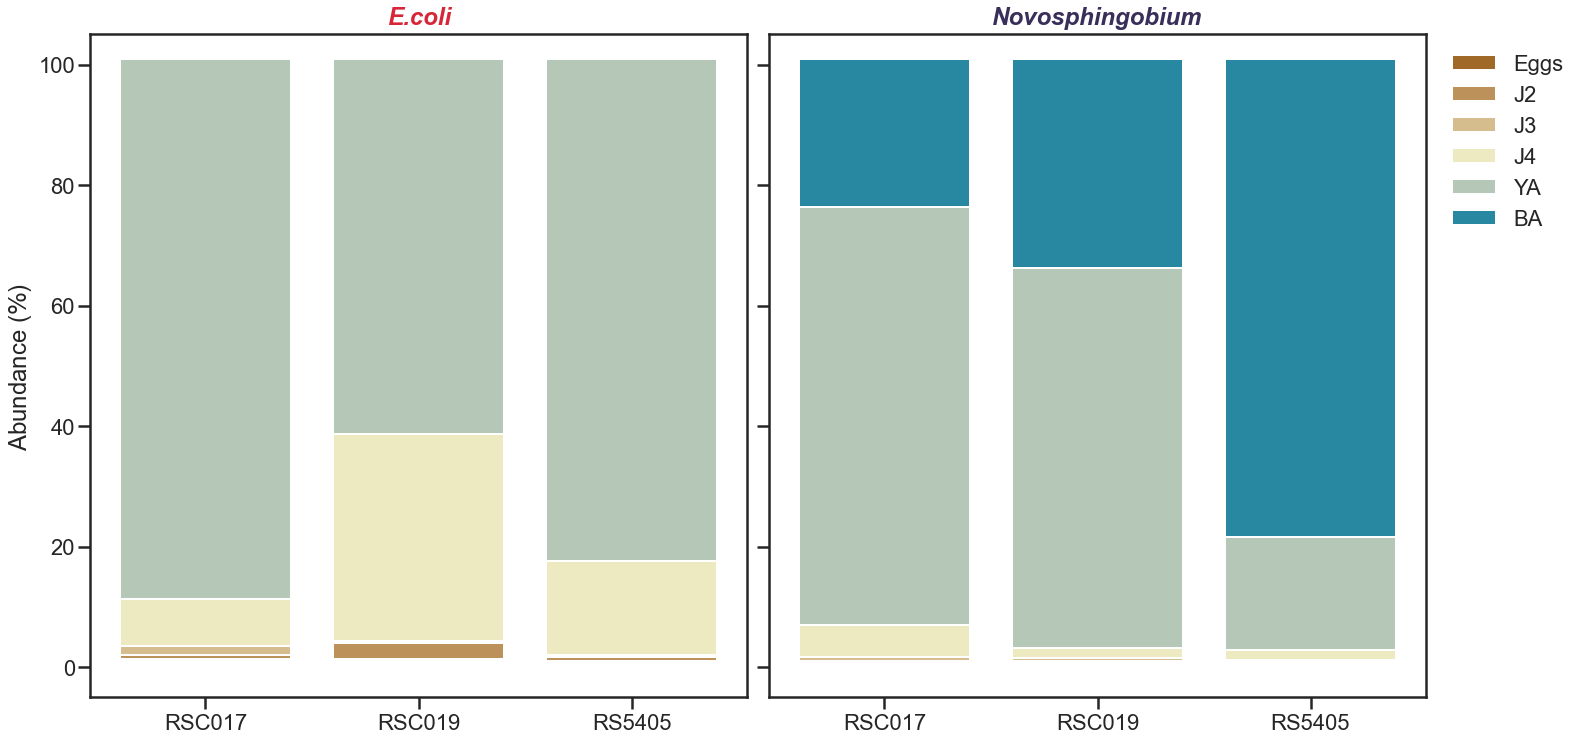

In [77]:
grad = ['#A16928','#bd925a','#d6bd8d','#edeac2','#b5c8b8','#2887a1'] 

fig, ax = plt.subplots(1, 2, figsize=(20,10))

for ind, pos in zip(['RSC017', 'RSC019', 'RS5405'], [0, 1, 2]):
    count = 0
    bot = 1
    for stage in ['Eggs', 'J2', 'J3', 'J4', 'YA', 'BA']:
        val = dev_isolate[(dev_isolate['Strain']==ind) & (dev_isolate['Stage']==stage) & (dev_isolate['Condition ']=='E.coli')]['Percentage']
        ax[0].bar(pos, val, bottom=bot, color=grad[count])
        bot += float(val)
        count += 1
ax[0].set_ylabel(r'Abundance ($\%$)')
ax[0].set_xticks([0, 1, 2])
ax[0].set_xticklabels(['RSC017', 'RSC019', 'RS5405'])   

for ind, pos in zip(['RSC017', 'RSC019', 'RS5405'], [0, 1, 2]):
    count = 0
    bot = 1
    for stage in ['Eggs', 'J2', 'J3', 'J4', 'YA', 'BA']:
        val = dev_isolate[(dev_isolate['Strain']==ind) & (dev_isolate['Stage']==stage) & (dev_isolate['Condition ']=='Novosphingobium sp.')]['Percentage']
        ax[1].bar(pos, val, bottom=bot, color=grad[count], label=stage)
        bot += float(val)
        count += 1
ax[1].set_xticks([0, 1, 2])
ax[1].set_xticklabels(['RSC017', 'RSC019', 'RS5405']) 
ax[0].set_ylim(-5, 105)
ax[1].set_ylim(-5, 105)
ax[1].set_yticklabels([])
handles, labels = plt.gca().get_legend_handles_labels()
fig.tight_layout()
plt.legend(handles[:6], labels[:6], bbox_to_anchor=(1.01, 1),frameon=False)
ax[0].set_title('E.coli', fontstyle='italic', weight='bold', color='#D72638', pad=10)
ax[1].set_title('Novosphingobium', fontstyle='italic', weight='bold', color='#392F5A', pad=10)
plt.savefig('./fig3c.pdf', bbox_inches='tight', dpi=300)